In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, LayerNormalization, ConvLSTM2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Task Name
task_name = "Brain Tumor Diagnosis from MRI Scan Images"

# Desired image dimensions
IMAGE_SIZE = (224, 224)
image_size = (224, 224, 3)


#List of categories, types & grades
labels = ['Meningima', 'Glioma', 'Pituitary']

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

#Batch Size
BATCH_SIZE = 64

In [3]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    ax.grid()


def load_data(data_path, image_size):

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        if '.csv' in category:
            continue
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category: ', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
            face_array=cv2.resize(pixels, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)
            img_data_list.append(face_array/255.)          
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels)
    data = np.array(img_data_list)
    
    #data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

In [4]:
image_size = (299,299,3)
data_path = "/kaggle/input/mycancerdb/matdata_classwise"
data, labels = load_data(data_path,image_size)

[INFO] Dataset Loading...

Loading : 1426 images of category:  2
Loading : 930 images of category:  3
Loading : 708 images of category:  1

Total number of uploaded data:  3064 , with data shape (299, 299, 3)


In [5]:
# Split the dataset into two subsets (80%-20%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=0, stratify=labels)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (2451, 299, 299, 3)
y_train has shape: (2451, 3)

X_test has shape: (613, 299, 299, 3)
y_test has shape: (613, 3)

X_train + X_test = 3064 samples in total


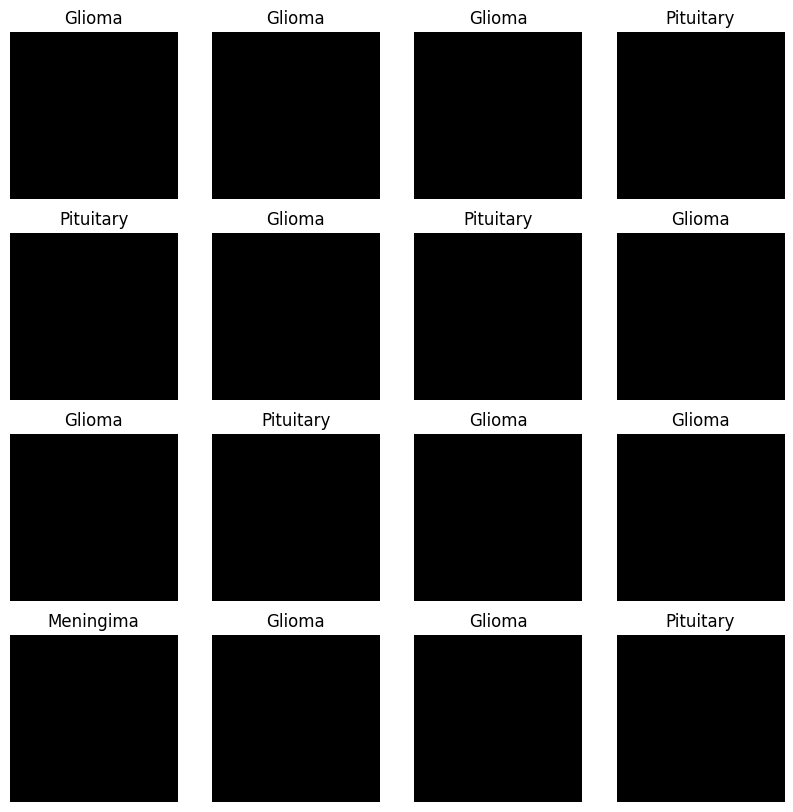

In [6]:
# Map the disease categories
#List of categories, types & grades
labels = ['Meningima', 'Glioma', 'Pituitary']
mapping = {0:labels[0], 1:labels[1], 2:labels[2]}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image))
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [7]:
def build_model():
    
    inputs = Input(shape=image_size)
    
    xception_model = Xception(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in xception_model.layers:
        layer.trainable=False
    xception_fmaps = xception_model.get_layer('block14_sepconv1_act').output
    
    irv2_model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in irv2_model.layers:
        layer.trainable=False
    irv2_fmaps = irv2_model.get_layer('conv_7b_ac').output
    
    #Add Squeeze Layer
    X_GAP = GlobalAveragePooling2D()(xception_fmaps)
    I_GAP = GlobalAveragePooling2D()(irv2_fmaps)
    
    #Xception Excitation
    FC1 = Dense(xception_fmaps.shape[3]//8, activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(X_GAP)
    FC2 = Dense(xception_fmaps.shape[3], activation='sigmoid',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(FC1)
    X_Att = Multiply()([X_GAP,FC2])
    
    #IRV2 Excitation
    FC1 = Dense(irv2_fmaps.shape[3]//8, activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(I_GAP)
    FC2 = Dense(irv2_fmaps.shape[3], activation='sigmoid',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(FC1)
    I_Att = Multiply()([I_GAP,FC2])
    
    #Fusion Layer
    fused_fmaps = Concatenate()([X_Att, I_Att])
    
    #Add Attention Classifier
    FC1 = Dense(fused_fmaps.shape[-1]//8, activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(fused_fmaps)
    FC2 = Dense(fused_fmaps.shape[-1], activation='sigmoid',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))(FC1)
    Att = Multiply()([fused_fmaps,FC2])
    Att = tf.keras.layers.LayerNormalization()(Att)
    outputs = Dense(3, activation='softmax')(Att)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#Adam(learning_rate=1e-3)

    return model

In [8]:
# Create an object of the model
model = build_model()

from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
        
#print(model.summary())
plot_model(model, show_shapes=True, to_file='model.png')

219055592/219055592 [==============================] - 3s 0us/step


In [9]:
EPOCHS = 100
batch_size = 32
filepath = "/kaggle/working/BTC_MSENet.h5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop] #earlystopping


print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=batch_size,callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 1.3087 - accuracy: 0.7572
Epoch 1: val_accuracy improved from -inf to 0.86786, saving model to /kaggle/working/BTC_MSENet.h5
77/77 [==============================] - 65s 511ms/step - loss: 1.3087 - accuracy: 0.7572 - val_loss: 0.7696 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.8768
Epoch 2: val_accuracy did not improve from 0.86786
77/77 [==============================] - 28s 370ms/step - loss: 0.6742 - accuracy: 0.8768 - val_loss: 0.6534 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8976
Epoch 3: val_accuracy improved from 0.86786 to 0.90049, saving model to /kaggle/working/BTC_MSENet.h5
77/77 [==============================] - 30s 397ms/step - loss: 0.5421 - accuracy: 0.8976 - val_loss: 0.4810 - val_accuracy: 0.900

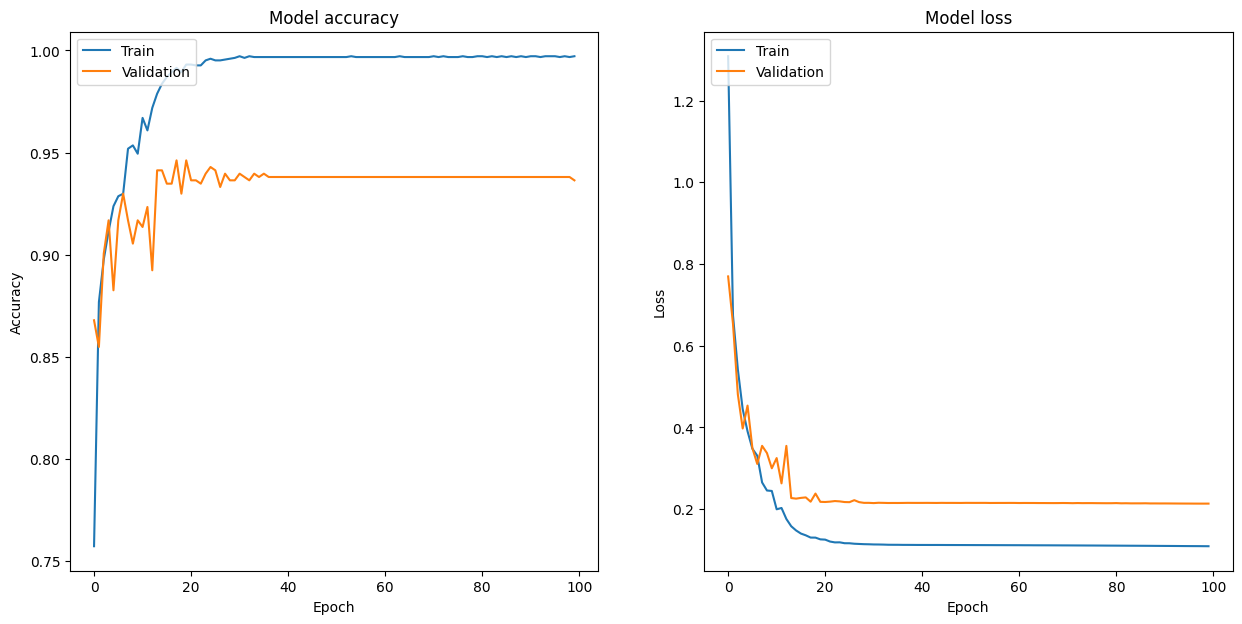

In [10]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [11]:
model = load_model(filepath)
model.evaluate(X_test,y_test)

20/20 [==============================] - 10s 285ms/step - loss: 0.2181 - accuracy: 0.9462


[0.21812130510807037, 0.9461663961410522]

In [12]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=-1)

20/20 [==============================] - 10s 281ms/step


In [13]:
Y_test = y_test
y_test = np.argmax(Y_test,axis=-1)

In [14]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(y_test,y_pred)
mpre = precision_score(y_test,y_pred,average='macro')
mrecall = recall_score(y_test,y_pred,average='macro')
mf1 = f1_score(y_test,y_pred,average='macro')
kappa = cohen_kappa_score(y_test,y_pred,weights='quadratic')

print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))

Accuracy:  94.62
Macro Precision:  94.11
Macro Recall:  93.77
Macro F1-Score:  93.93
Quadratic Kappa Score:  91.18


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4, target_names = labels))

              precision    recall  f1-score   support

   Meningima     0.8986    0.8732    0.8857       142
      Glioma     0.9514    0.9614    0.9564       285
   Pituitary     0.9733    0.9785    0.9759       186

    accuracy                         0.9462       613
   macro avg     0.9411    0.9377    0.9393       613
weighted avg     0.9458    0.9462    0.9459       613

